In [79]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular
# the data
import faraway.datasets.fat

In [80]:
# Here we isolate the data. I am dropping siri and density because they are both essentially
# just alternative ways to measure brozek, which is a percent body fat equation
df = faraway.datasets.fat.load()
df = df.drop("siri", axis=1)
df = df.drop("density", axis=1)
df.head()

,brozek,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.6,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [81]:
df = df.rename(columns={"brozek":"y"})

/Users/evanwireman/Documents/SchoolSpring2021/ExperimentalDesign/LogitRegProject/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/evanwireman/Documents/SchoolSpring2021/ExperimentalDesign/LogitRegProject/env/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


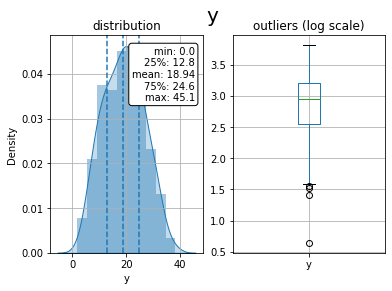

In [82]:
x = "y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

In [83]:
def test_corr(x, y):
    dtf_noNan = df[df[x].notnull()]
    coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
    coeff, p = round(coeff, 3), round(p, 3)
    conclusion = "Significant" if p < 0.05 else "Non-Significant"
    print("Pearson Correlation between "+x+" and "+y+":", coeff, conclusion, "(p-value: "+str(p)+")")

In [84]:
for (columnName, columnData) in df.iteritems():
    if columnName == "brozek":
        pass
    test_corr(columnName, "y")

Pearson Correlation between y and y: 1.0 Significant (p-value: 0.0)
Pearson Correlation between age and y: 0.289 Significant (p-value: 0.0)
Pearson Correlation between weight and y: 0.613 Significant (p-value: 0.0)
Pearson Correlation between height and y: -0.089 Non-Significant (p-value: 0.158)
Pearson Correlation between adipos and y: 0.728 Significant (p-value: 0.0)
Pearson Correlation between free and y: 0.02 Non-Significant (p-value: 0.75)
Pearson Correlation between neck and y: 0.491 Significant (p-value: 0.0)
Pearson Correlation between chest and y: 0.703 Significant (p-value: 0.0)
Pearson Correlation between abdom and y: 0.814 Significant (p-value: 0.0)
Pearson Correlation between hip and y: 0.626 Significant (p-value: 0.0)
Pearson Correlation between thigh and y: 0.561 Significant (p-value: 0.0)
Pearson Correlation between knee and y: 0.508 Significant (p-value: 0.0)
Pearson Correlation between ankle and y: 0.267 Significant (p-value: 0.0)
Pearson Correlation between biceps an

In [85]:
# From this we can tell that free and height are non-significant and can be ommited from the regression model

In [86]:
## split data
df_train, df_test = model_selection.train_test_split(df, 
                      test_size=0.3)
## print info
print("X_train shape:", df_train.drop("y",axis=1).shape, "| X_test shape:", df_test.drop("y",axis=1).shape)
print("y_train mean:", round(np.mean(df_train["y"]),2), "| y_test mean:", round(np.mean(df_test["y"]),2))
print(df_train.shape[1], "features:", df_train.drop("y",axis=1).columns.to_list())

X_train shape: (176, 15) | X_test shape: (76, 15)
y_train mean: 19.03 | y_test mean: 18.74
16 features: ['age', 'weight', 'height', 'adipos', 'free', 'neck', 'chest', 'abdom', 'hip', 'thigh', 'knee', 'ankle', 'biceps', 'forearm', 'wrist']


In [87]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(df_train.drop("y", axis=1))
df_scaled= pd.DataFrame(X, columns=df_train.drop("y", 
                        axis=1).columns, index=df_train.index)
## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
df_scaled["y"] = scalerY.fit_transform(
                    df_train["y"].values.reshape(-1,1))
df_scaled.head()

,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist,y
212,0.328767,-0.205298,0.466667,-0.414201,-0.184549,0.112903,-0.110403,-0.129371,-0.026578,-0.441667,0.140351,0.148148,-0.689655,-0.285714,0.285714,-0.009112
40,0.109589,2.298013,-0.333333,3.396450,1.527897,1.693548,2.437367,2.423077,3.495017,2.258333,0.421053,1.925926,1.213793,1.542857,2.285714,1.248292
34,-0.109589,1.887417,0.933333,1.763314,1.296137,1.338710,1.477707,1.681818,2.232558,2.041667,1.719298,1.777778,1.462069,1.161905,1.071429,1.066059
90,0.164384,0.026490,0.000000,0.153846,0.047210,-0.241935,0.008493,0.283217,0.385382,-0.108333,-0.070175,-0.098765,-0.800000,-0.361905,-0.357143,0.072893
119,0.054795,0.304636,0.600000,0.130178,0.583691,0.016129,0.186837,-0.283217,0.225914,-0.075000,0.280702,0.888889,0.027586,-0.019048,-0.142857,-0.136674


<AxesSubplot:xlabel='selection', ylabel='features'>

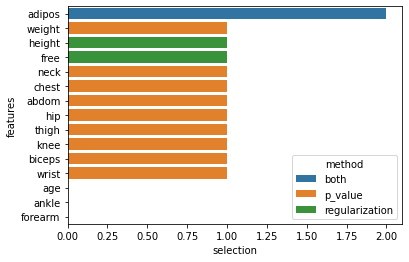

In [88]:
# feature selection
X = df_train.drop("y", axis=1).values
y = df_train["y"].values
feature_names = df_train.drop("y", axis=1).columns
## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=10).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=10).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
df_features = pd.DataFrame({"features":feature_names})
df_features["p_value"] = df_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
df_features["num1"] = df_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
df_features["regularization"] = df_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
df_features["num2"] = df_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
df_features["method"] = df_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
df_features["selection"] = df_features["num1"] + df_features["num2"]
df_features["method"] = df_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=df_features.sort_values("selection", ascending=False), dodge=False)

/Users/evanwireman/Documents/SchoolSpring2021/ExperimentalDesign/LogitRegProject/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/evanwireman/Documents/SchoolSpring2021/ExperimentalDesign/LogitRegProject/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


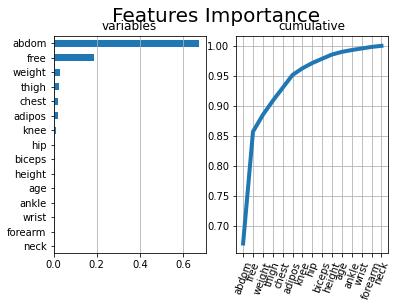

In [89]:
X = df_train.drop("y", axis=1).values
y = df_train["y"].values
feature_names = df_train.drop("y", axis=1).columns.tolist()
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
df_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
df_importances['cumsum'] =  df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), 
          xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [90]:
# using the information above, I select the following features:
X_names = ['abdom', 'free', "weight", "adipos"]
X_train = df_train[X_names].values
y_train = df_train["y"].values
X_test = df_test[X_names].values
y_test = df_test["y"].values

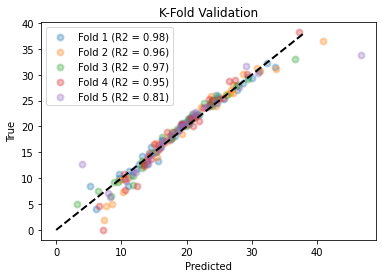

In [91]:
## call model
model = linear_model.LinearRegression()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [92]:
# The model is producing very high R^2 values on the training set. Now to test
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

In [93]:
#predicted = scalerY.inverse_transform( predicted.reshape(-1,1) ).reshape(-1)

In [94]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.98
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.06
Mean Absolute Error (Σ|y-pred|/n): 1
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 1
Max Error: -3


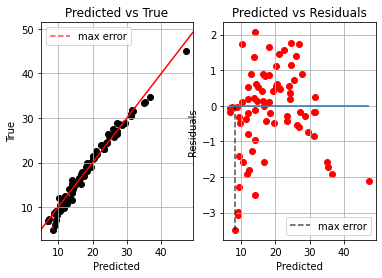

In [95]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

/Users/evanwireman/Documents/SchoolSpring2021/ExperimentalDesign/LogitRegProject/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


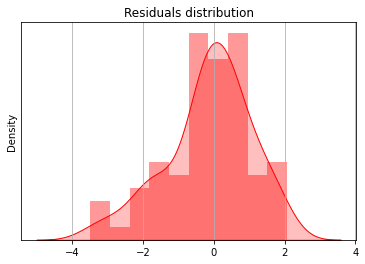

In [96]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

In [97]:
print("True:", "{:,.0f}".format(y_test[1]), "--> Pred:", "{:,.0f}".format(predicted[1]))

True: 29 --> Pred: 27


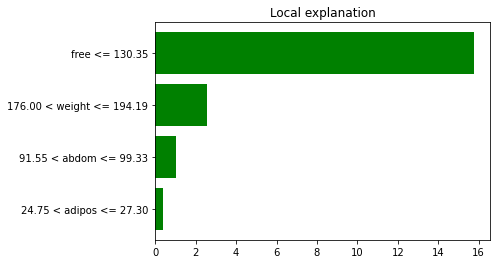

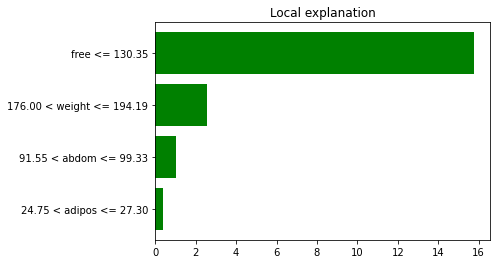

In [98]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Y", mode="regression")
explained = explainer.explain_instance(X_test[1], model.predict, num_features=10)
explained.as_pyplot_figure()